In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from backtesting import Backtest, Strategy
from scipy.stats import spearmanr
import argparse

In [161]:
import pandas as pd

# 读取三个数据集
df_vix = pd.read_csv("daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("daily_sentiment_bert.csv", parse_dates=["date"])

# 筛选日期范围
start_date = "2018-01-01"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# 添加前缀：VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# 添加前缀：NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# 情感数据也筛选日期范围
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# 依次合并
df_merged = df_all.merge(df_sentiscores, on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# 查看缺失值
print("Missing values per column:")
print(df_merged.isnull().sum())

# 查看合并后的数据
print(df_merged.head())

# 保存结果
df_merged.to_csv("factor_data.csv", index=False)

Missing values per column:
date                     0
avg_sentiment_score     11
vix_open               473
vix_high               473
vix_low                473
vix_close              473
nvda_open              473
nvda_high              473
nvda_low               473
nvda_close             473
nvda_volume            473
dtype: int64
        date  avg_sentiment_score  vix_open  vix_high  vix_low  vix_close  \
0 2018-01-01             0.000000       NaN       NaN      NaN        NaN   
1 2018-01-02             0.111111     10.95     11.07     9.52       9.77   
2 2018-01-03             0.246154      9.56      9.65     8.94       9.15   
3 2018-01-04             0.200000      9.01      9.31     8.92       9.22   
4 2018-01-05             0.157895      9.10      9.54     9.00       9.22   

   nvda_open  nvda_high  nvda_low  nvda_close  nvda_volume  
0        NaN        NaN       NaN         NaN          NaN  
1    4.84138    4.93344   4.80971     4.92975  356569996.0  
2    5.04737    5

In [228]:
# 1. 数据预处理（假设df是已经合并的DataFrame）
def preprocess_data(df):
    # 确保date列存在
    if 'date' not in df.columns:
        raise ValueError("数据必须包含'date'列")
    
    # 设置日期索引
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # 处理缺失值
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    
    # 计算未来收益
    df['future_5d_ret'] = df['nvda_close'].pct_change(5).shift(-5)
    
    return df

# 2. 因子构建
def build_factors(df):
    factors = df.copy()
    
    # 1. 情绪因子（FinBERT）
    factors['sentiment_factor'] = factors['avg_sentiment_score']
    
    # 2. VIX因子（机构情绪）
    factors['vix_factor'] = StandardScaler().fit_transform(factors[['vix_close']])
    
    # 3. NVDA技术因子
    # 价格动量（5日）
    factors['nvda_momentum'] = factors['nvda_close'].pct_change(5)
    # 波动率（5日收益率标准差）
    factors['nvda_volatility'] = factors['nvda_close'].pct_change().rolling(5).std()
    # 成交量变化（5日）
    factors['nvda_volume_change'] = factors['nvda_volume'].pct_change(5)
    
    # 标准化技术因子
    tech_factors = ['nvda_momentum', 'nvda_volatility', 'nvda_volume_change']
    factors[tech_factors] = StandardScaler().fit_transform(factors[tech_factors])
    
    # 合并技术因子为综合得分（等权重）
    factors['tech_factor'] = factors[tech_factors].mean(axis=1)
    
    return factors

# 3. 综合指数构建
def build_composite_index(factors_df):
    # 选择因子列
    factor_cols = ['sentiment_factor', 'vix_factor', 'tech_factor']
    
    # 标准化因子
    factors_standardized = factors_df[factor_cols].apply(
        lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
    )
    
    return factors_standardized.mean(axis=1)

# 4. 因子分析
def analyze_factors(factors_df, composite_index):
    # 因子相关性
    corr_matrix = factors_df[['sentiment_factor', 'vix_factor', 'tech_factor']].corr()
    print("因子相关性矩阵:\n", corr_matrix)
    
    # 因子与未来收益的IC分析
    def calculate_ic(factor, ret, lag=5):
        valid_idx = ~pd.isna(factor) & ~pd.isna(ret)
        return spearmanr(factor[valid_idx], ret[valid_idx]).correlation
    
    ic_results = {
        'sentiment': calculate_ic(factors_df['sentiment_factor'], factors_df['future_5d_ret']),
        'vix': calculate_ic(factors_df['vix_factor'], factors_df['future_5d_ret']),
        'tech': calculate_ic(factors_df['tech_factor'], factors_df['future_5d_ret'])
    }
    print("\n因子IC值（5日收益）:", ic_results)
    
    # 可视化综合指数
    plt.figure(figsize=(12, 6))
    composite_index.plot(title='Composite Index')
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

# 5. 回测策略
class CompositeIndexStrategy(Strategy):
    def init(self):
        composite = self.data.composite_index
        ci_ma = self.data.ci_ma
        self.signal = self.I(lambda x, y: x > y, composite, ci_ma)

    def next(self):
        if self.signal[-1] and not self.position:
            self.buy()
        elif not self.signal[-1] and self.position:
            self.position.close()

In [234]:
# Visualization

def plot_factor_vs_price(df, composite_index):
    plt.figure(figsize=(14, 7))
    
    # 左轴：价格
    ax1 = plt.gca()
    ax1.plot(df.index, df['nvda_close'], color='tab:blue', label='NVDA Price')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.tick_params(axis='y', colors='tab:blue')
    
    # 右轴：综合指数
    ax2 = ax1.twinx()
    ax2.plot(df.index, composite_index, color='tab:orange', alpha=0.7, label='Composite Index')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_ylabel('Composite Index', color='tab:orange')
    ax2.tick_params(axis='y', colors='tab:orange')
    
    # 标注信号点（需回测后获取）
    if 'signal' in df.columns:
        buy_signals = df[df['signal'] == 1]
        sell_signals = df[df['signal'] == -1]
        ax1.scatter(buy_signals.index, buy_signals['nvda_close'], 
                   color='green', marker='^', alpha=1, label='Buy')
        ax1.scatter(sell_signals.index, sell_signals['nvda_close'],
                   color='red', marker='v', alpha=1, label='Sell')
        
    if 'ci_ma' in df.columns:
        ax2.plot(df.index, df['ci_ma'], color='tab:red', linestyle='--', label='Composite Index MA')
        
        plt.title('Composite Index vs NVDA Price with Trading Signals')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

def plot_factor_correlation(factors_df):
    plt.figure(figsize=(8, 6))
    corr = factors_df[['sentiment_factor', 'vix_factor', 'tech_factor']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Factor Correlation Matrix')
    plt.show()

def plot_factor_group_returns(factors_df):
# 按情绪因子分组
    factors_df['sentiment_group'] = pd.qcut(factors_df['sentiment_factor'], 5, labels=[1,2,3,4,5])
    group_returns = factors_df.groupby('sentiment_group')['future_5d_ret'].mean()
    
    plt.figure(figsize=(10, 5))
    group_returns.plot(kind='bar', color='skyblue')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title('Future 5-Day Returns by Sentiment Factor Quintile')
    plt.xlabel('Sentiment Group (1=Lowest, 5=Highest)')
    plt.ylabel('Mean Future Return')
    plt.show()

def enhanced_backtest_plots(returns, benchmark_returns):
    """
    绘制策略收益 vs 基准收益 的累计收益对比图。
    
    参数:
    - returns: 策略每日收益 (Series)
    - benchmark_returns: 基准每日收益 (Series)
    """

    # 对齐两个序列
    combined = pd.DataFrame({
        'strategy': returns,
        'benchmark': benchmark_returns
    }).dropna()

    # 累计收益
    cumulative = (1 + combined).cumprod()
    for year in pd.to_datetime(cumulative.index).year.unique():
        plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle=':', alpha=0.3)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)

    # 绘图
    plt.figure(figsize=(12, 6))   
    plt.text(0.02, 0.95, f'Sharpe: {sharpe:.2f}', transform=plt.gca().transAxes,fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.plot(cumulative.index, cumulative['strategy'], label='Strategy', linewidth=2)
    plt.plot(cumulative.index, cumulative['benchmark'], label='Benchmark', linestyle='--', linewidth=2)
    plt.title('Cumulative Returns: Strategy vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

原始数据形状: (1520, 11)
预处理后数据形状: (1519, 11)

生成因子分析可视化...


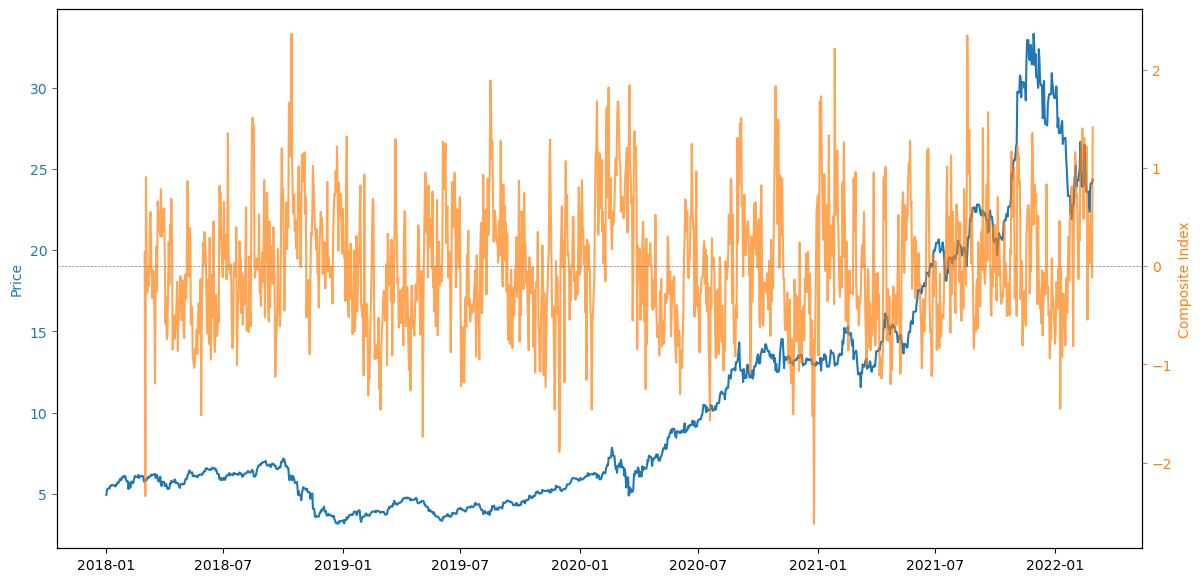

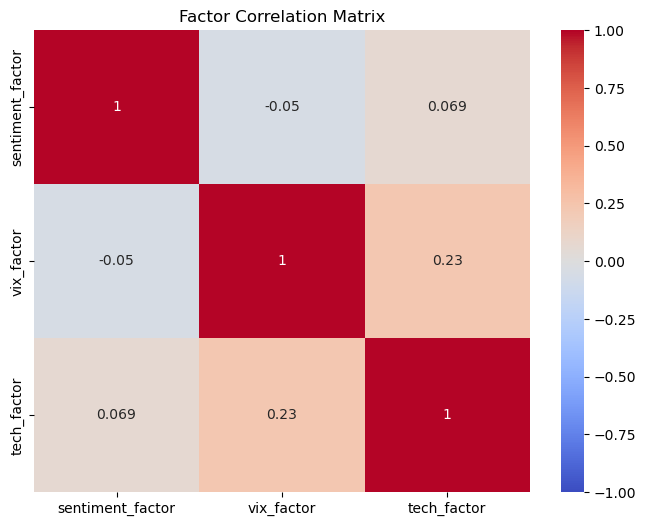

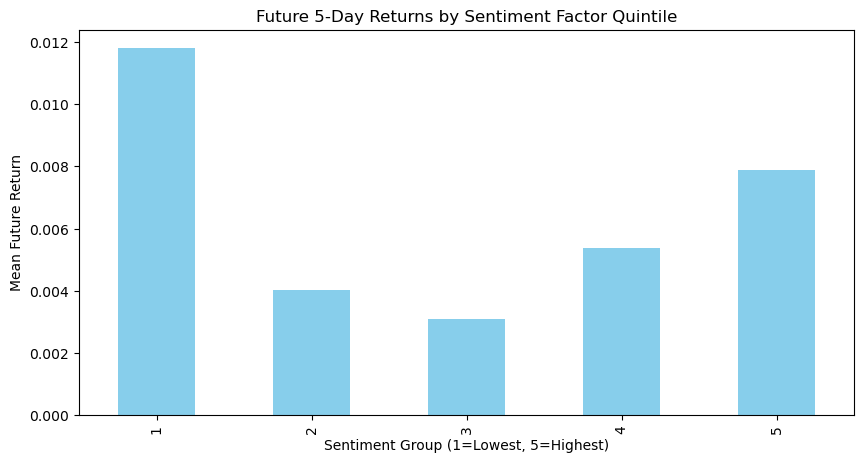


运行回测...


Backtest.run:   0%|          | 0/1450 [00:00<?, ?bar/s]

Start                     2018-03-11 00:00:00
End                       2022-02-28 00:00:00
Duration                   1450 days 00:00:00
Exposure Time [%]                    63.26671
Equity Final [$]                   8136.63802
Equity Peak [$]                   16544.15979
Commissions [$]                    4160.04264
Return [%]                          -18.63362
Buy & Hold Return [%]               300.98563
Return (Ann.) [%]                    -5.05494
Volatility (Ann.) [%]                37.15967
CAGR [%]                             -5.05833
Sharpe Ratio                         -0.13603
Sortino Ratio                        -0.17781
Calmar Ratio                         -0.08268
Alpha [%]                           -175.7303
Beta                                  0.52194
Max. Drawdown [%]                   -61.13934
Avg. Drawdown [%]                   -10.09465
Max. Drawdown Duration      959 days 00:00:00
Avg. Drawdown Duration       79 days 00:00:00
# Trades                          

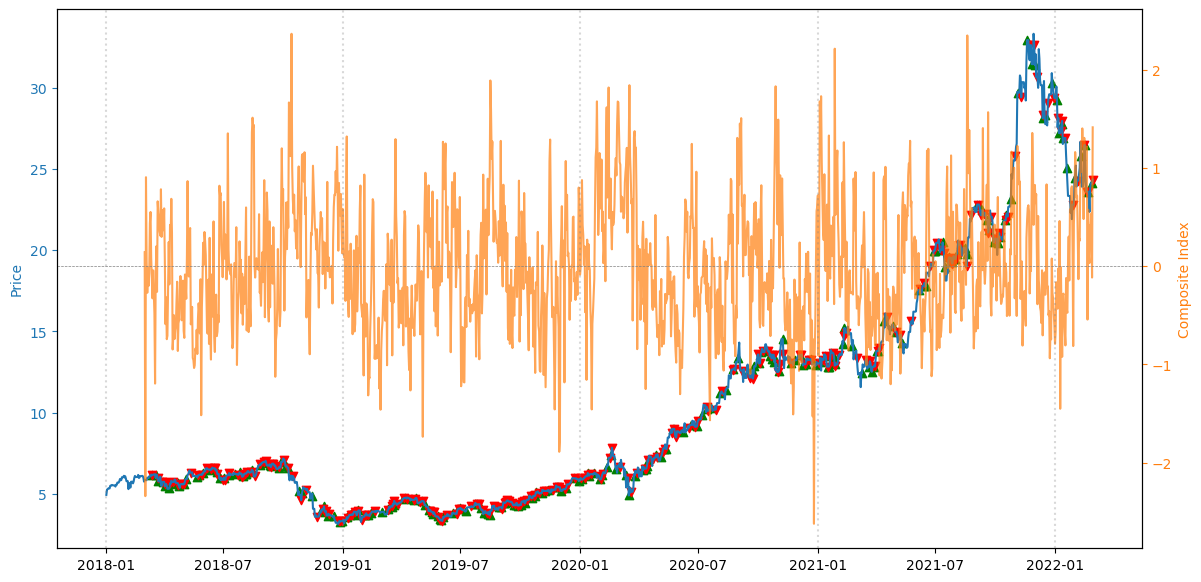

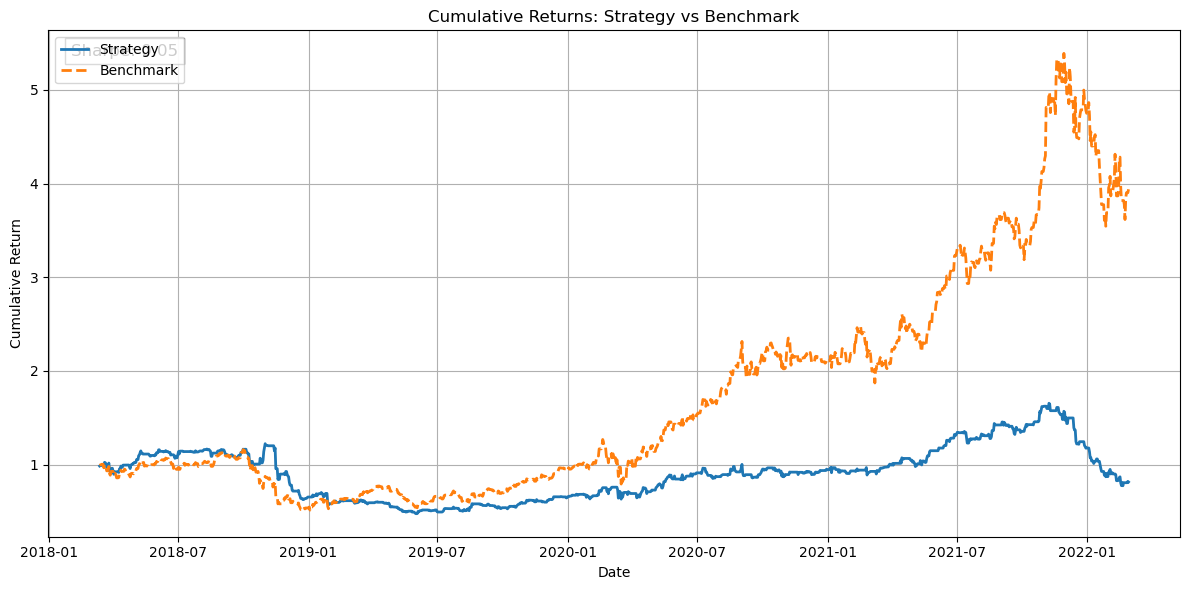

In [236]:
def main():
    try:
        # 1. 加载数据
        df = pd.read_csv('factor_data.csv')
        print("原始数据形状:", df.shape)
        
        # 2. 预处理
        df = preprocess_data(df)
        print("预处理后数据形状:", df.shape)
        
        # 3. 构建因子
        factors = build_factors(df)
        
        # 4. 综合指数
        factors['composite_index'] = build_composite_index(factors)
        
        # ========== 调用可视化函数 ==========
        print("\n生成因子分析可视化...")
        # 因子与价格对比图
        plot_factor_vs_price(factors, factors['composite_index'])
        
        # 因子相关性热力图
        plot_factor_correlation(factors)
        
        # 因子分组收益
        plot_factor_group_returns(factors)
        
         # 5. 回测准备
        backtest_data = df[['nvda_open', 'nvda_high', 'nvda_low', 'nvda_close']].copy()
        backtest_data.columns = ['Open', 'High', 'Low', 'Close']
        backtest_data['composite_index'] = factors['composite_index']  # 添加composite_index列
        backtest_data['ci_ma'] = factors['composite_index'].rolling(10).mean()  # 计算10日均线
        backtest_data.dropna(inplace=True)

        # 6. 运行回测
        print("\n运行回测...")
        bt = Backtest(backtest_data, CompositeIndexStrategy, commission=0.001)
        results = bt.run()
        print(results)
        
        # 标注交易信号
        factors['signal'] = 0
        if hasattr(results, '_trades') and results._trades is not None:
            print(f"生成 {len(results._trades)} 笔交易")
            
            # 确保日期转换并标准化（去除时分秒）
            entry_dates = pd.to_datetime(results._trades['EntryTime']).dt.normalize()
            exit_dates = pd.to_datetime(results._trades['ExitTime']).dt.normalize()
            
            # 转换为日期字符串格式以匹配索引
            entry_dates = entry_dates.dt.strftime('%Y-%m-%d')
            exit_dates = exit_dates.dt.strftime('%Y-%m-%d')
            
            factors['signal'] = 0
            factors.loc[factors.index.strftime('%Y-%m-%d').isin(entry_dates), 'signal'] = 1
            factors.loc[factors.index.strftime('%Y-%m-%d').isin(exit_dates), 'signal'] = -1
        else:
            print("警告：没有生成任何交易")
        
        # 带信号的因子价格图
        plot_factor_vs_price(factors, factors['composite_index'])
        
        # 策略每日收益
        equity_curve = results['_equity_curve']  # 注意这里是属性而不是字典
        returns = equity_curve['Equity'].pct_change().dropna()
        
        # 基准每日收益
        benchmark_returns = df['nvda_close'].loc[returns.index].pct_change().dropna()
        
        # 调用可视化函数
        enhanced_backtest_plots(returns, benchmark_returns)
        
    except Exception as e:
        print(f"错误: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()